# Определение перспективного тарифа для телеком компании Мегалайн

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
data_users = pd.read_csv('/datasets/users.csv')
data_calls = pd.read_csv('/datasets/calls.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
print(data_users.info())
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
print(data_calls.info())
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
print(data_messages.info())
data_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
print(data_internet.info())
data_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
print(data_tariffs.info())
data_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Шаг 2. Подготовьте данные

Далее при работе с таблицами нам нужно будет анализировать активность клиентов по месяцам. Cразу добавим в таблицы <code>data_calls</code>, <code>data_messages</code>, <code>data_internet</code> колонку Месяц.

In [8]:
# Приведем колонки к типу Дата (в т.ч. для таблицы data_users)
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')

data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

# и добавим колонку месяц
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

В описании проекта сказано: <i>"Обратите внимание, что у большого количества звонков длительность — 0.0 минут. Это проблема в данных, нужна предобработка."</i>

Проведем предварительный анализ для колонки <code>duration</code> в таблице <code>data_calls</code> и колонки <code>mb_used</code> в таблице <code>data_internet</code>.

39613
202607


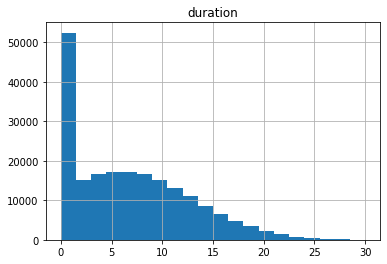

In [9]:
data_calls.hist('duration', range=(0, 30), bins=20)
print(data_calls.query('duration == 0').shape[0])
print(data_calls.shape[0])

19598
149396


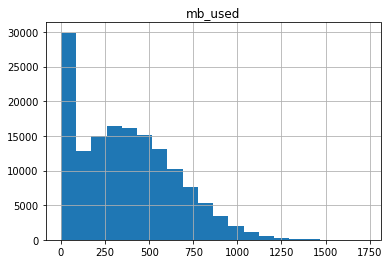

In [10]:
data_internet.hist('mb_used', bins=20)
print(data_internet.query('mb_used == 0').shape[0])
print(data_internet.shape[0])

Давайте рассуждать (на примере звонков - для интернета аналогично):
1. 20% данных duration пустые - это критически много
2. Если их просто проигнорировать и выкинуть из таблицы звонков, то в результате мы не сможем точно утвержать превысил ли клиент свой месячный лимит по звонкам и, следовательно, не оценим итоговую сумму платежа клиента за месяц
3. Если предположить, что duration = 0 это что-то вроде неудачного звонка (или линия занята)? Тоже странно - каждый 5-ый звонок неудачный?

Если бы это бы не учебный проект, то я бы просто отправил баг-репорт ответственному за выгрузку. В условиях нехватки информации - придется покопать.

Может это несколько отдельных пользователей выгрузилось неудачно, тогда мы просто отсечем часть user_id из исследования и пойдем дальше?

In [11]:
print('Нулевые значения в data_call у', len(data_calls.query('duration == 0').groupby('user_id')['user_id'].count()), 'пользователей')
print('Нулевые значения в data_internet у', len(data_internet.query('mb_used == 0').groupby('user_id')['user_id'].count()), 'пользователей')

Нулевые значения в data_call у 492 пользователей
Нулевые значения в data_internet у 494 пользователей


Увы. У 492 пользователей из 500 есть нулевые значения. Принимаю решение: заполнить нулевые значения продолжительности звонка и потраченного интернет трафика - средней продолжительностью для данного пользователя за данный месяц.

In [12]:
# Процедура заполняет нулевые значения в таблице data в колонки column 
# средним значением для данного пользователя (user_id) за данный месяц (month)
def fill_zero_values(data, column):
    # Формируем сводную таблицу
    data_mean = data.query(column + ' != 0').pivot_table(index=['user_id', 'month'], values=column)

    # Превращаем сводную таблицу в обычную (плоскую), переименовываем столбцы
    data_mean = data_mean.reset_index()
    data_mean.columns = ['user_id', 'month', column + '_mean']

    # Соединяем data с data_mean и заполняем нулевые значения в колонке column
    # средними значениями из колонки column_mean
    data = data.merge(data_mean, on=['user_id', 'month'], how='left')
    data.loc[data[column] == 0, column] = data[column + '_mean']

    # Удаляем ненужную теперь колонку column_mean
    data.drop(column + '_mean', axis=1, inplace=True)
    return data
    
data_calls = fill_zero_values(data_calls, 'duration')
data_internet = fill_zero_values(data_internet, 'mb_used')

# Проверим, что нулевых значений не осталось
print(data_calls.query('duration == 0').shape[0])
print(data_internet.query('mb_used == 0').shape[0])

0
0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8e840190>]],
      dtype=object)

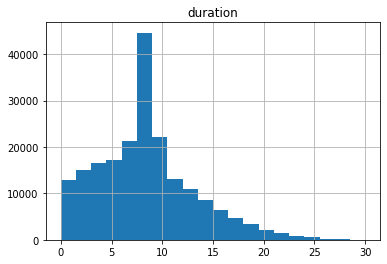

In [13]:
data_calls.hist('duration', range=(0, 30), bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c8f421990>]],
      dtype=object)

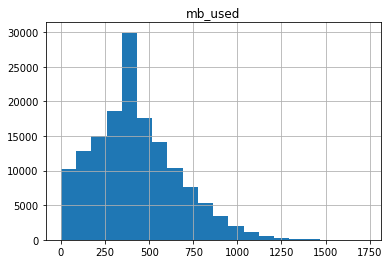

In [14]:
data_internet.hist('mb_used', bins=20)

Полосы из 0 ожидаемо "растеклись" по распределению. В середине случился "горб".

#### Таблица <code>data_users</code>

In [15]:
# Проверим колонки на корректность заполнения
print(np.sort(data_users['age'].unique()))
print(np.sort(data_users['city'].unique()))
print(np.sort(data_users['tariff'].unique()))

[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]
['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ростов-на-Дону' 'Рязань' 'Самара' 'Санкт-Петербург' 'Саранск' 'Саратов'
 'Севастополь' 'Смоленск' 'Сочи' 'Ставрополь' 'Стерлитамак' 'Сургут'
 'Тамбов' 'Тверь' 'Тольятти' 'Томск' 'Тула' 'Тюмень' 'Улан-Удэ'
 'Ульяновск' 'Уфа' 'Хабаровск' 'Химки' 'Чебоксары' 'Челябинск' 'Че

In [16]:
# Необходимо также убедиться, что в таблице нет разных клиентов с одинаковым user_id
set(data_users.groupby('user_id')['user_id'].count().values)

{1}

#### Таблица <code>data_calls</code>

Ранее убедились, что все значения заполнены. Дополнительных проверок проводить не будем.

Нулевые значения в колонке <code>duration</code> заполнил.

#### Таблица <code>data_messages</code>

Ранее убедились, что все значения заполнены. Дополнительных проверок проводить не будем.

#### Таблица <code>data_internet</code>

Ранее убедились, что все значения заполнены. Дополнительных проверок проводить не будем.

Нулевые значения в колонке <code>mb_used</code> заполнил.

#### Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для этого создадим новую таблицу <code>data_costs</code>

In [17]:
# Используем pd.concat
data_costs = pd.concat([data_calls, data_messages, data_internet], ignore_index=True, sort=False)

# Для удобства работы с данными о сообщениях добавим колонку с 1
data_costs.loc[data_costs['message_date'].notnull(), 'messages'] = 1

In [18]:
# Чтобы примерно понимать, что мы в итоге наобъединяли, выведем таблицу для одного из user_id
data_costs.query('user_id == 1496 and month == 1')

,id,call_date,duration,user_id,month,message_date,mb_used,session_date,messages
201223,1496_45,2018-01-31,7.626667,1496,1,NaT,NaN,NaT,NaN
201414,1496_236,2018-01-29,11.140000,1496,1,NaT,NaN,NaT,NaN
201533,1496_355,2018-01-28,7.930000,1496,1,NaT,NaN,NaT,NaN
201694,1496_516,2018-01-31,3.260000,1496,1,NaT,NaN,NaT,NaN
201793,1496_615,2018-01-27,1.990000,1496,1,NaT,NaN,NaT,NaN
201842,1496_664,2018-01-30,8.500000,1496,1,NaT,NaN,NaT,NaN
201992,1496_814,2018-01-31,12.940000,1496,1,NaT,NaN,NaT,NaN
324792,1496_20,NaT,NaN,1496,1,2018-01-30,NaN,NaT,1.0
324909,1496_137,NaT,NaN,1496,1,2018-01-30,NaN,NaT,1.0
324910,1496_138,NaT,NaN,1496,1,2018-01-29,NaN,NaT,1.0


Не забываем про предупреждение в условиях задачи: <i>Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.</i>

In [19]:
data_costs.loc[data_costs['duration'].notnull(), 'duration'] = np.ceil(data_costs['duration'])
data_costs.loc[data_costs['mb_used'].notnull(), 'mb_used'] = np.ceil(data_costs['mb_used'])
data_costs.query('user_id == 1496 and month == 1')

,id,call_date,duration,user_id,month,message_date,mb_used,session_date,messages
201223,1496_45,2018-01-31,8.0,1496,1,NaT,NaN,NaT,NaN
201414,1496_236,2018-01-29,12.0,1496,1,NaT,NaN,NaT,NaN
201533,1496_355,2018-01-28,8.0,1496,1,NaT,NaN,NaT,NaN
201694,1496_516,2018-01-31,4.0,1496,1,NaT,NaN,NaT,NaN
201793,1496_615,2018-01-27,2.0,1496,1,NaT,NaN,NaT,NaN
201842,1496_664,2018-01-30,9.0,1496,1,NaT,NaN,NaT,NaN
201992,1496_814,2018-01-31,13.0,1496,1,NaT,NaN,NaT,NaN
324792,1496_20,NaT,NaN,1496,1,2018-01-30,NaN,NaT,1.0
324909,1496_137,NaT,NaN,1496,1,2018-01-30,NaN,NaT,1.0
324910,1496_138,NaT,NaN,1496,1,2018-01-29,NaN,NaT,1.0


In [20]:
# Далее мы формируем сводную таблицу
data_costs = data_costs.pivot_table(index=['user_id', 'month'], values=['duration', 'messages', 'mb_used'], aggfunc='sum')
data_costs = data_costs.reset_index()
data_costs

,user_id,month,duration,mb_used,messages
0,1000,5,204.0,2820.0,22.0
1,1000,6,262.0,25902.0,60.0
2,1000,7,388.0,14517.0,75.0
3,1000,8,508.0,15112.0,81.0
4,1000,9,586.0,15747.0,57.0
...,...,...,...,...,...
3209,1498,10,335.0,24804.0,42.0
3210,1499,9,79.0,2310.0,11.0
3211,1499,10,689.0,24019.0,48.0
3212,1499,11,732.0,22594.0,59.0


Для расчета выручки к полученной таблице присоединим таблицу <code>data_users</code>, чтобы получить тариф для каждого пользователя, а затем таблицу <code>data_tariffs</code>

In [21]:
data_revenue = data_costs.merge(data_users, on='user_id', how='left')

# Удаляем лишние колонки, присоединенные из data_users
data_revenue.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'], axis=1, inplace=True)

data_revenue = data_revenue.merge(data_tariffs, left_on='tariff', right_on='tariff_name', how='left')

# Удаляем лишние колонки, присоединенные из data_tariffs
data_revenue.drop('tariff_name', axis=1, inplace=True)

In [22]:
data_revenue

,user_id,month,duration,mb_used,messages,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,204.0,2820.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,262.0,25902.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,388.0,14517.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,508.0,15112.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,586.0,15747.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,335.0,24804.0,42.0,Владикавказ,smart,50,15360,500,550,200,3,3
3210,1499,9,79.0,2310.0,11.0,Пермь,smart,50,15360,500,550,200,3,3
3211,1499,10,689.0,24019.0,48.0,Пермь,smart,50,15360,500,550,200,3,3
3212,1499,11,732.0,22594.0,59.0,Пермь,smart,50,15360,500,550,200,3,3


In [23]:
# Добавим колонки extra_duration, extra_messages и extra_mb_used показывающие траты сверх лимита
data_revenue.loc[data_revenue['duration'] > data_revenue['minutes_included'], 'extra_duration'] = data_revenue['duration'] - data_revenue['minutes_included']
data_revenue.loc[data_revenue['messages'] > data_revenue['messages_included'], 'extra_messages'] = data_revenue['messages'] - data_revenue['messages_included']
data_revenue.loc[data_revenue['mb_used'] > data_revenue['mg_per_month_included'], 'extra_mb_used'] = data_revenue['mb_used'] - data_revenue['mg_per_month_included']

data_revenue.loc[data_revenue['duration'] <= data_revenue['minutes_included'], 'extra_duration'] = 0
data_revenue.loc[data_revenue['messages'] <= data_revenue['messages_included'], 'extra_messages'] = 0
data_revenue.loc[data_revenue['mb_used'] <= data_revenue['mg_per_month_included'], 'extra_mb_used'] = 0

# и посчитаем выручку по каждому пользователю
data_revenue['revenue'] = (
    data_revenue['rub_monthly_fee']
    + data_revenue['extra_duration'] * data_revenue['rub_per_minute']
    + data_revenue['extra_messages'] * data_revenue['rub_per_message']
    + data_revenue['extra_mb_used'] / 1000 * data_revenue['rub_per_gb']
)

In [24]:
data_revenue

,user_id,month,duration,mb_used,messages,city,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_duration,extra_messages,extra_mb_used,revenue
0,1000,5,204.0,2820.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6,262.0,25902.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7,388.0,14517.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8,508.0,15112.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9,586.0,15747.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,335.0,24804.0,42.0,Владикавказ,smart,50,15360,500,550,200,3,3,0.0,0.0,9444.0,2438.8
3210,1499,9,79.0,2310.0,11.0,Пермь,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
3211,1499,10,689.0,24019.0,48.0,Пермь,smart,50,15360,500,550,200,3,3,189.0,0.0,8659.0,2848.8
3212,1499,11,732.0,22594.0,59.0,Пермь,smart,50,15360,500,550,200,3,3,232.0,9.0,7234.0,2719.8


### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [25]:
# Реализуем процедуру, которая сравнивает показатели для 2-х тарифов, 
# а также строит сравнительную гистограмму, показывающую использование тарифа клентами.
# 
# В параметре column_included указывается имя колонки в таблице data_tariffs,
# в которой хранятся значения включенных в тариф лимитов на связь:
# messages_included, mg_per_month_included или minutes_included
def show_data_indicators(param, column_included):
    data_smart = data_revenue.query('tariff == "smart"')
    data_ultra = data_revenue.query('tariff == "ultra"')
    
    if (param == 'mb_used'):
        data_smart.loc[:, param] = data_smart[param] / 1000
        data_ultra.loc[:, param] = data_ultra[param] / 1000
        
    print(param)
    
    print('|{:<50}|{:<10}|{:<10}|'.format('', 'smart', 'ultra'))
    
    # Расчитываем и выводим среднее, дисперсию и отклонение
    smart_mean = data_smart[param].mean()
    ultra_mean = data_ultra[param].mean()
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Среднее', smart_mean, ultra_mean))
    
    smart_var = np.var(data_smart[param], ddof=1)
    ultra_var = np.var(data_ultra[param], ddof=1)
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Дисперсия', smart_var, ultra_var))
    
    smart_std = np.sqrt(smart_var)
    ultra_std = np.sqrt(ultra_var)
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Отклонение', smart_std, ultra_std))
    
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Среднее + 3 * Отклонение', smart_mean + 3 * smart_std, ultra_mean + 3 * ultra_std))

    # Дополнительно выводим лимиты, включенные в тариф
    smart_included = data_tariffs.query('tariff_name == "smart"').loc[:, column_included].values[0]
    ultra_included = data_tariffs.query('tariff_name == "ultra"').loc[:, column_included].values[0]
    if (param == 'mb_used'):
        smart_included = smart_included / 1000
        ultra_included = ultra_included / 1000
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Включено в тариф', smart_included, ultra_included))
    
    # Расcчитаем для какого % строк (пользователей + месяцев) было превышение лимита, включенного в тариф
    smart_overrun_ratio = 100 * data_smart.query(param + ' >= @smart_included').shape[0] / data_smart.shape[0]
    ultra_overrun_ratio = 100 * data_ultra.query(param + ' >= @ultra_included').shape[0] / data_ultra.shape[0]
    print('|{:<50}|{:>10.2f}|{:>10.2f}|'.format('Превышений лимита, включенного в тариф, %', smart_overrun_ratio, ultra_overrun_ratio))
    
    plt.hist(data_smart[param], bins=20, alpha=0.5, label='smart', density=True)
    plt.hist(data_ultra[param], bins=20, alpha=0.5, label='ultra', density=True)
    plt.legend(loc='upper right')
    plt.show()

duration
|                                                  |smart     |ultra     |
|Среднее                                           |    520.22|    652.61|
|Дисперсия                                         |  54907.74| 154050.07|
|Отклонение                                        |    234.32|    392.49|
|Среднее + 3 * Отклонение                          |   1223.19|   1830.09|
|Включено в тариф                                  |    500.00|   3000.00|
|Превышений лимита, включенного в тариф, %         |     55.18|      0.00|


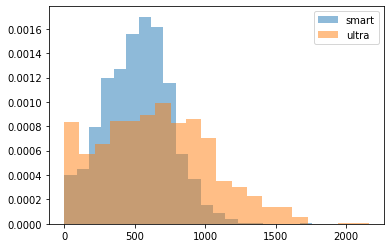

In [26]:
show_data_indicators('duration', 'minutes_included')

Что касается звонков, то пользователи тарифа Smart в среднем лишь слегка превышают границу тарифа (520 мин в месяц, при включенных в тариф 500 минутах). Превышение по звонкам наблюдается практически у каждого 2-го пользователя тарифа Smart (55%).

Пользователи тарифа Ultra имеют в своем распоряжении аж 3000 минут, но совсем их не используют. Дажее "среднее + 3 * отклонения" сильно не доходит до включенного в тариф лимита.

messages
|                                                  |smart     |ultra     |
|Среднее                                           |     33.38|     49.36|
|Дисперсия                                         |    796.81|   2285.27|
|Отклонение                                        |     28.23|     47.80|
|Среднее + 3 * Отклонение                          |    118.07|    192.78|
|Включено в тариф                                  |     50.00|   1000.00|
|Превышений лимита, включенного в тариф, %         |     26.07|      0.00|


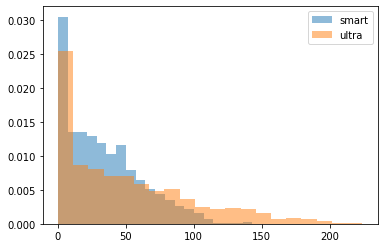

In [27]:
show_data_indicators('messages', 'messages_included')

1. Обращает внимание столб около 0. Значительное число абонентов практически не пользуются сообщениями. Тут, конечно, требуется перепроверка полученной выгрузки, но очевидное объяснение также существует: сейчас активно используются мессенджеры, и смски становятся неактуальными.
2. Также как и со звонками пользовтели ultra никогда не добираются до установленного лимита. Для пользователей тарифа smart превышение возникает лишь в 1 из 4 случаев (26%).

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


mb_used
|                                                  |smart     |ultra     |
|Среднее                                           |     19.32|     20.44|
|Дисперсия                                         |     47.66|    111.49|
|Отклонение                                        |      6.90|     10.56|
|Среднее + 3 * Отклонение                          |     40.03|     52.12|
|Включено в тариф                                  |     15.36|     30.72|
|Превышений лимита, включенного в тариф, %         |     73.89|     17.36|


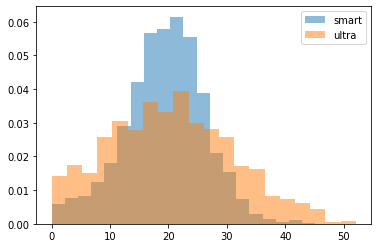

In [28]:
show_data_indicators('mb_used', 'mg_per_month_included')

Интернет трафик используется максимально пользователями обоих тарифов. 74% пользователей тарифа smart не хватает включенного в тариф объема. Среднему пользователю тарифа ultra хватает установленного лимита, и только 17% перерасходует его.

Заметим, что у пользователей тарифа ultra только для услуги интернета наблюдается превышение лимита у части пользователей. Для телефонных звонков и сообщений пользователь с вероятностью 99% никогда не израсходуют установленный лимит.

## Шаг 4. Проверьте гипотезы

### Гипотеза 1 "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Формулируем нулевую гипотезу. Мы имеет 2 генеральные совокупности: выручку пользователей тарифа Смарт и выручку пользователей тарифа Ультра. Нулевая гипотеза состоит в предположении о равенстве средних двух этих совокупностей.

In [29]:
alpha = 0.05

results = st.ttest_ind(data_revenue.query('tariff == "smart"')['revenue'], data_revenue.query('tariff == "ultra"')['revenue'], equal_var=False)
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.623212187766969e-10
Отвергаем нулевую гипотезу


Интересно в принципе посмотреть на средние величины выручки разных тарифов.

In [30]:
print(data_revenue.query('tariff == "smart"')['revenue'].mean())
print(data_revenue.query('tariff == "ultra"')['revenue'].mean())

1924.3371915657244
2103.3881725888327


В итоге мы можем отвергнуть нулевую гипотезу и делаем вывод, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

### Гипотеза 2 "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Формулируем нулевую гипотезу. Мы имеет 2 генеральные совокупности: выручку пользователей Москвы и выручку пользователей других городов. Нулевая гипотеза состоит в предположении о равенстве средних двух этих совокупностей.

In [31]:
results = st.ttest_ind(data_revenue.query('city == "Москва"')['revenue'], data_revenue.query('city != "Москва"')['revenue'], equal_var=False)
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.4515290978053206
Не получилось отвергнуть нулевую гипотезу


Интересно в принципе посмотреть на средние величины выручки Москвы и других городов.

In [32]:
print(data_revenue.query('city == "Москва"')['revenue'].mean())
print(data_revenue.query('city != "Москва"')['revenue'].mean())

1953.0475450081833
1985.3526315789475


В итоге мы не можем отвергнуть нулевую гипотезу и делаем вывод, что средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов.

## Общий вывод

Были изучены данные компании Мегалайн.

При анализе данных бли замечены следующие аномалии: в данных о звонках и интернет-сессиях присутствует большое количество нулевых значений (продолжительность звонка = 0, объем трафика = 0 МБ). Безусловно, это требует уточнения у отвественного за выгрузку сотрудника: сейчас за неимением возможности обратиться к кому-либо принял решение заполнить нулевые значения средними значениями по пользователю за данный месяц.

При анализе расходов клиентов разных тарифов выявлены следующие закономерности:
* клиенты тарифа Ультра практически никогда не используют лимит звонков и сообщений, так что с маркетинговой точки зрения можно на порядок увеличить лимит звонков и сообщений для этого тарифа и ничего от этого не потерять
* значительная часть пользователей обоих тарифов практически не использует смс сообщения, предполагаю, что виной этому активное использование мессенджеров
* у пользователей обоих тарифов наблюдается превышение лимита интернет-трафика

Также мы проверили 2 гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

В результате проверки этих гипотез пришли к ПРЕДВАРИТЕЛЬНОМУ выводу:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов